In [1]:
# Finding vectors

## Input data

 - Folder with files
 - Indices of shuffled files
 - Output folder
 - Range of files to be used
 - Batch size
 - Save every n batches

In [2]:
import os
import sys
import errno

import math
from glob import glob
from pathlib import Path
from PIL import Image
from urllib.parse import urlparse
from math import log2
from pathlib import Path

import numpy as np
from einops import rearrange, reduce, repeat
from tqdm import tqdm
from kornia.filters import filter2d

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torchvision.transforms import v2
from torch.hub import download_url_to_file, HASH_REGEX
try:
    from torch.hub import get_dir
except BaseException:
    from torch.hub import _get_torch_home as get_dir


torch.manual_seed(42)

In [3]:
INPUT_FOLDER = "/media/pawel/DATA/tmp/freddie_mercuries/en_face/aligned"
OUTPUT_FOLDER = "/media/pawel/DATA/tmp/freddie_mercuries/en_face/new_new_vectors"

START_FROM = 90000
N_BATCHES = 25*70
BATCH_SIZE = 4    # CHANGE TO A DIVISOR OF 100 fi.e. 2, 4, 5, 10, 

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
glob_name = f"{INPUT_FOLDER}/*.jpg"
path_names = [Path(p) for p in sorted(glob(glob_name))]
assert path_names, "path_names cannot be empty, check your input folder name"
Path(OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

IMG_SIZE = 256
LATENT_DIM = 256

SAVE_EVERY_N_BATCHES = 100 // BATCH_SIZE
assert BATCH_SIZE * SAVE_EVERY_N_BATCHES == 100, "Batch size is improper"

permutation_array = np.load("permuted_100000.npy")
assert path_names, "permutation array cannot be empty, check your input folder name"

path_names_permuted = [path_names[i] for i in permutation_array]

In [5]:
def exists(val):
    return val is not None

def get_1d_dct(i, freq, L):
    result = math.cos(math.pi * freq * (i + 0.5) / L) / math.sqrt(L)
    return result * (1 if freq == 0 else math.sqrt(2))

def is_power_of_two(val):
    return log2(val).is_integer()

def default(val, d):
    return val if exists(val) else d

def get_dct_weights(width, channel, fidx_u, fidx_v):
    dct_weights = torch.zeros(1, channel, width, width)
    c_part = channel // len(fidx_u)

    for i, (u_x, v_y) in enumerate(zip(fidx_u, fidx_v)):
        for x in range(width):
            for y in range(width):
                coor_value = get_1d_dct(x, u_x, width) * get_1d_dct(y, v_y, width)
                dct_weights[:, i * c_part: (i + 1) * c_part, x, y] = coor_value

    return dct_weights

def Conv2dSame(dim_in, dim_out, kernel_size, bias = True):
    pad_left = kernel_size // 2
    pad_right = (pad_left - 1) if (kernel_size % 2) == 0 else pad_left

    return nn.Sequential(
        nn.ZeroPad2d((pad_left, pad_right, pad_left, pad_right)),
        nn.Conv2d(dim_in, dim_out, kernel_size, bias = bias)
    )

class ChanNorm(nn.Module):
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) / (var + self.eps).sqrt() * self.g + self.b


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = ChanNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x))


class DepthWiseConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding = 0, stride = 1, bias = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size = kernel_size, padding = padding, groups = dim_in, stride = stride, bias = bias),
            nn.Conv2d(dim_in, dim_out, kernel_size = 1, bias = bias)
        )
    def forward(self, x):
        return self.net(x)


class LinearAttention(nn.Module):
    def __init__(self, dim, dim_head = 64, heads = 8, kernel_size = 3):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.dim_head = dim_head
        inner_dim = dim_head * heads

        self.kernel_size = kernel_size
        self.nonlin = nn.GELU()

        self.to_lin_q = nn.Conv2d(dim, inner_dim, 1, bias = False)
        self.to_lin_kv = DepthWiseConv2d(dim, inner_dim * 2, 3, padding = 1, bias = False)

        self.to_q = nn.Conv2d(dim, inner_dim, 1, bias = False)
        self.to_kv = nn.Conv2d(dim, inner_dim * 2, 1, bias = False)

        self.to_out = nn.Conv2d(inner_dim * 2, dim, 1)

    def forward(self, fmap):
        h, x, y = self.heads, *fmap.shape[-2:]

        # linear attention

        lin_q, lin_k, lin_v = (self.to_lin_q(fmap), *self.to_lin_kv(fmap).chunk(2, dim = 1))
        lin_q, lin_k, lin_v = map(lambda t: rearrange(t, 'b (h c) x y -> (b h) (x y) c', h = h), (lin_q, lin_k, lin_v))

        lin_q = lin_q.softmax(dim = -1)
        lin_k = lin_k.softmax(dim = -2)

        lin_q = lin_q * self.scale

        context = einsum('b n d, b n e -> b d e', lin_k, lin_v)
        lin_out = einsum('b n d, b d e -> b n e', lin_q, context)
        lin_out = rearrange(lin_out, '(b h) (x y) d -> b (h d) x y', h = h, x = x, y = y)

        # conv-like full attention

        q, k, v = (self.to_q(fmap), *self.to_kv(fmap).chunk(2, dim = 1))
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> (b h) c x y', h = h), (q, k, v))

        k = F.unfold(k, kernel_size = self.kernel_size, padding = self.kernel_size // 2)
        v = F.unfold(v, kernel_size = self.kernel_size, padding = self.kernel_size // 2)

        k, v = map(lambda t: rearrange(t, 'b (d j) n -> b n j d', d = self.dim_head), (k, v))

        q = rearrange(q, 'b c ... -> b (...) c') * self.scale

        sim = einsum('b i d, b i j d -> b i j', q, k)
        sim = sim - sim.amax(dim = -1, keepdim = True).detach()

        attn = sim.softmax(dim = -1)

        full_out = einsum('b i j, b i j d -> b i d', attn, v)
        full_out = rearrange(full_out, '(b h) (x y) d -> b (h d) x y', h = h, x = x, y = y)

        # add outputs of linear attention + conv like full attention

        lin_out = self.nonlin(lin_out)
        out = torch.cat((lin_out, full_out), dim = 1)
        return self.to_out(out)


class FCANet(nn.Module):
    def __init__(
        self,
        *,
        chan_in,
        chan_out,
        reduction = 4,
        width
    ):
        super().__init__()

        freq_w, freq_h = ([0] * 8), list(range(8)) # in paper, it seems 16 frequencies was ideal
        dct_weights = get_dct_weights(width, chan_in, [*freq_w, *freq_h], [*freq_h, *freq_w])
        self.register_buffer('dct_weights', dct_weights)

        chan_intermediate = max(3, chan_out // reduction)

        self.net = nn.Sequential(
            nn.Conv2d(chan_in, chan_intermediate, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(chan_intermediate, chan_out, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = reduce(x * self.dct_weights, 'b c (h h1) (w w1) -> b c h1 w1', 'sum', h1 = 1, w1 = 1)
        return self.net(x)

class GlobalContext(nn.Module):
    def __init__(
        self,
        *,
        chan_in,
        chan_out
    ):
        super().__init__()
        self.to_k = nn.Conv2d(chan_in, 1, 1)
        chan_intermediate = max(3, chan_out // 2)

        self.net = nn.Sequential(
            nn.Conv2d(chan_in, chan_intermediate, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(chan_intermediate, chan_out, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        context = self.to_k(x)
        context = context.flatten(2).softmax(dim = -1)
        out = einsum('b i n, b c n -> b c i', context, x.flatten(2))
        out = out.unsqueeze(-1)
        return self.net(out)


class Noise(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1))

    def forward(self, x, noise = None):
        b = x.shape[0]
        h = x.shape[2]
        w = x.shape[3] 
        device = x.device

        if not exists(noise):
            noise = torch.randn(b, 1, h, w, device = device)

        return x + self.weight * noise


class PixelShuffleUpsample(nn.Module):
    def __init__(self, dim, dim_out = None):
        super().__init__()
        dim_out = default(dim_out, dim)
        conv = nn.Conv2d(dim, dim_out * 4, 1)

        self.net = nn.Sequential(
            conv,
            nn.SiLU(),
            nn.PixelShuffle(2)
        )

        self.init_conv_(conv)

    def init_conv_(self, conv):
        o, i, h, w = conv.weight.shape
        conv_weight = torch.empty(o // 4, i, h, w)
        nn.init.kaiming_uniform_(conv_weight)
        conv_weight = repeat(conv_weight, 'o ... -> (o 4) ...')

        conv.weight.data.copy_(conv_weight)
        nn.init.zeros_(conv.bias.data)

    def forward(self, x):
        return self.net(x)

    
class Blur(nn.Module):
    def __init__(self):
        super().__init__()
        f = torch.Tensor([1, 2, 1])
        self.register_buffer('f', f)
    def forward(self, x):
        f = self.f
        f = f[None, None, :] * f [None, :, None]
        return filter2d(x, f, normalized=True)


class Generator(nn.Module):
    def __init__(
        self,
        *,
        image_size = IMG_SIZE,
        latent_dim = LATENT_DIM,
        fmap_max = 512,
        fmap_inverse_coef = 12,
        transparent = False,
        greyscale = False,
        attn_res_layers = [32],
        freq_chan_attn = False,
    ):
        super().__init__()
        resolution = log2(image_size)
        assert is_power_of_two(image_size), 'image size must be a power of 2'

        if transparent:
            init_channel = 4
        elif greyscale:
            init_channel = 1
        else:
            init_channel = 3

        fmap_max = default(fmap_max, latent_dim)

        self.initial_conv = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, latent_dim * 2, 4),
            nn.BatchNorm2d(latent_dim * 2),
            nn.GLU(dim = 1)
        )

        num_layers = int(resolution) - 2
        features = list(map(lambda n: (n,  2 ** (fmap_inverse_coef - n)), range(2, num_layers + 2)))
        features = list(map(lambda n: (n[0], min(n[1], fmap_max)), features))
        features = list(map(lambda n: 3 if n[0] >= 8 else n[1], features))
        features = [latent_dim, *features]

        in_out_features = list(zip(features[:-1], features[1:]))

        self.res_layers = range(2, num_layers + 2)
        self.layers = nn.ModuleList([])
        self.res_to_feature_map = dict(zip(self.res_layers, in_out_features))

        self.sle_map = ((3, 7), (4, 8), (5, 9), (6, 10))
        self.sle_map = list(filter(lambda t: t[0] <= resolution and t[1] <= resolution, self.sle_map))
        self.sle_map = dict(self.sle_map)

        self.num_layers_spatial_res = 1

        for (res, (chan_in, chan_out)) in zip(self.res_layers, in_out_features):
            image_width = 2 ** res
            attn = None
            if image_width in attn_res_layers:
                attn = PreNorm(chan_in, LinearAttention(chan_in))

            sle = None
            if res in self.sle_map:
                residual_layer = self.sle_map[res]
                sle_chan_out = self.res_to_feature_map[residual_layer - 1][-1]

                if freq_chan_attn:
                    sle = FCANet(
                        chan_in = chan_out,
                        chan_out = sle_chan_out,
                        width = 2 ** (res + 1)
                    )
                else:
                    sle = GlobalContext(
                        chan_in = chan_out,
                        chan_out = sle_chan_out
                    )

            layer = nn.ModuleList([
                nn.Sequential(
                    PixelShuffleUpsample(chan_in),
                    Blur(),
                    Conv2dSame(chan_in, chan_out * 2, 4),
                    Noise(),
                    nn.BatchNorm2d(chan_out * 2),
                    nn.GLU(dim = 1)
                ),
                sle,
                attn
            ])
            self.layers.append(layer)

        self.out_conv = nn.Conv2d(features[-1], init_channel, 3, padding = 1)

    def forward(self, x):
        x = rearrange(x, 'b c -> b c () ()')
        x = self.initial_conv(x)
        x = F.normalize(x, dim = 1)

        residuals = dict()

        for (res, (up, sle, attn)) in zip(self.res_layers, self.layers):
            if exists(attn):
                x = attn(x) + x

            x = up(x)

            if exists(sle):
                out_res = self.sle_map[res]
                residual = sle(x)
                residuals[out_res] = residual

            next_res = res + 1
            if next_res in residuals:
                x = x * residuals[next_res]

        return self.out_conv(x)

In [6]:


# landmarks model

def load_file_from_url(url, model_dir=None, progress=True, check_hash=False, file_name=None):
    if model_dir is None:
        hub_dir = get_dir()
        model_dir = os.path.join(hub_dir, 'checkpoints')

    try:
        os.makedirs(model_dir)
    except OSError as e:
        if e.errno == errno.EEXIST:
            # Directory already exists, ignore.
            pass
        else:
            # Unexpected OSError, re-raise.
            raise

    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if file_name is not None:
        filename = file_name
    cached_file = os.path.join(model_dir, filename)
    if not os.path.exists(cached_file):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
        hash_prefix = None
        if check_hash:
            r = HASH_REGEX.search(filename)  # r is Optional[Match[str]]
            hash_prefix = r.group(1) if r else None
        download_url_to_file(url, cached_file, hash_prefix, progress=progress)

    return cached_file


def load_landmarks_model():
    two_d_model_url = "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip"
    return torch.jit.load(load_file_from_url(two_d_model_url)).eval().to(DEVICE)


# Generator
def load_generator() -> torch.nn.Module:
    state_dict = torch.load("./model/generator_dict.pt")
    
    new_generator = Generator()
    new_generator.load_state_dict(state_dict)
    return new_generator.to(DEVICE).eval()


class DifferentiableLandmarks(torch.nn.Module):
    def __init__(self, generator, landmarks_model, images: torch.Tensor = None):
        super().__init__()
        self.z = torch.nn.Parameter(pick_best_random_z(images, generator))
        
        self.landmarks_model = landmarks_model
        self.generator = generator
        self.generator.eval()
        self.landmarks_model.eval()
               
        for p in self.generator.parameters():
            p.requires_grad = False
            
        for p in self.landmarks_model.parameters():
            p.requires_grad = False
        
        self.curr_image = self.generator(self.z)
        
        
    def forward(self):
        self.curr_image = self.generator(self.z)
        return self.landmarks_model(self.curr_image)
    
    def get_z(self) -> torch.Tensor:
        return self.z.clone().detach().cpu()
    
    def print_are_training(self):
        print("Are training:")
        print(f"Generator: {self.generator.training}")
        print(f"Landmarks: {self.landmarks_model.training}")
        print(f"Model: {self.training}")
        
        
def pick_best_random_z(images: torch.Tensor, generator: torch.nn.Module, n=100, criterion=torch.nn.MSELoss()) -> torch.Tensor:
    batch_size = images.shape[0]
    z = torch.randn( (batch_size, LATENT_DIM), requires_grad=True, device=DEVICE)
    z_best = z.clone()
    loss_best = float("inf")
    
    for _ in range(n):
        z = torch.randn( (batch_size, LATENT_DIM), requires_grad=True, device=DEVICE)
        images_gen = generator(z)
        with torch.no_grad():
            loss = criterion(images, images_gen)
            if loss < loss_best:
                z_best = z.clone()
                loss_best = loss.clone()
            
    return z_best
    
        
def find_z(images: torch.Tensor, lr=1e-2, iters=200) -> torch.Tensor:   
    generator = load_generator().to(DEVICE)
    landmarks_model = load_landmarks_model()
    model = DifferentiableLandmarks(generator, landmarks_model, images)
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    y_target = landmarks_model(images).detach()
    
    for _ in range(iters):
        y_pred = model()
        loss = criterion(y_target, y_pred) + 5 * criterion(images, model.curr_image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return  model.get_z()

def prep_image(filename)-> torch.tensor:
    image = Image.open(filename).convert("RGB")
    image_min_size = min(image.size)
    transforms = v2.Compose([
        v2.ToImage(),
        v2.CenterCrop(image_min_size),
        v2.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        v2.ToDtype(torch.float32, scale=True)
    ])
    return transforms(image).to(DEVICE)

def create_outpath(package_num: int, folder: str) -> str:
    return f"{folder}/package_{package_num:04d}.npy"

def load_checkpoint_num() -> str:
    filenames = [Path(filepath) for filepath in glob(f"{OUTPUT_FOLDER}/*.npy")]
    numbers = [int(filename.stem[-4:]) for filename in filenames]
    return max(numbers) + 1 if numbers else START_FROM // 100

In [7]:
z_list = []
saved_z = []
package_num = load_checkpoint_num()  # change to get_last_package_num(OUTPUT_FOLDER) if you want to continue from last package
START_FROM = package_num * 100
START_FROM, package_num = 78000, 780
print(f"Starting from image number {START_FROM} (Next package number: {package_num})")
for i in tqdm(range(N_BATCHES)):
    batch = torch.cat([prep_image(p).unsqueeze(0) for p in path_names_permuted[(BATCH_SIZE*i + START_FROM):(BATCH_SIZE*(i+1) + START_FROM)]])
    z = find_z(batch).numpy()
    z_list.append(z)
    
    if i % SAVE_EVERY_N_BATCHES == (SAVE_EVERY_N_BATCHES - 1):
        z_list = np.array(z_list).reshape((-1, 256))
        np.save(create_outpath(package_num, OUTPUT_FOLDER), z_list)
        saved_z.append(create_outpath(package_num, OUTPUT_FOLDER))
        package_num += 1
        z_list = []
        
        

Starting from image number 80000 (Next package number: 800)


  0%|          | 0/1750 [00:00<?, ?it/s]

 12%|█▏        | 214/1750 [9:59:25<71:28:15, 167.51s/it]

Does it work?

In [ ]:
from matplotlib import pyplot as plt

def prep_tensor_to_show(tensor):
    return tensor.permute(1, 2, 0).detach().to('cpu').numpy()

def show_tensor_picture(tensor, title=""):
    im_arr = prep_tensor_to_show(tensor)
    plt.title(title)
    plt.axis("off")
    plt.imshow(im_arr)
    

def plot_images(images, labels, nrows, ncols, step=1, title="", figsize=[8, 4]):
    """Plot nrows x ncols images from images and set labels as titles."""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        idx = i * step
        if images[i].shape[-1] == 1:
            ax.imshow((images[i]).reshape(images[idx].shape[0], images[idx].shape[1]))
        else:
            ax.imshow((images[idx]))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[idx])
    fig.suptitle(title)
    plt.tight_layout()
    # plt.savefig(f"{title}.png")
    plt.show()


In [ ]:
start_idx, last_idx = START_FROM, (BATCH_SIZE * N_BATCHES) + START_FROM
files_that_were_infered = [np.array(Image.open(p)) for p in path_names_permuted[start_idx:last_idx]]

generator = load_generator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


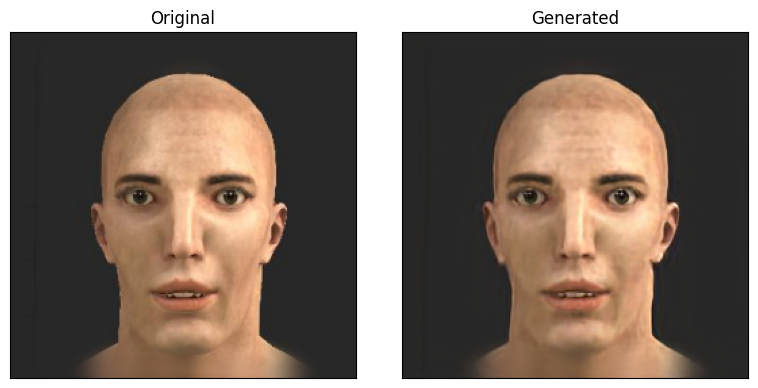

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


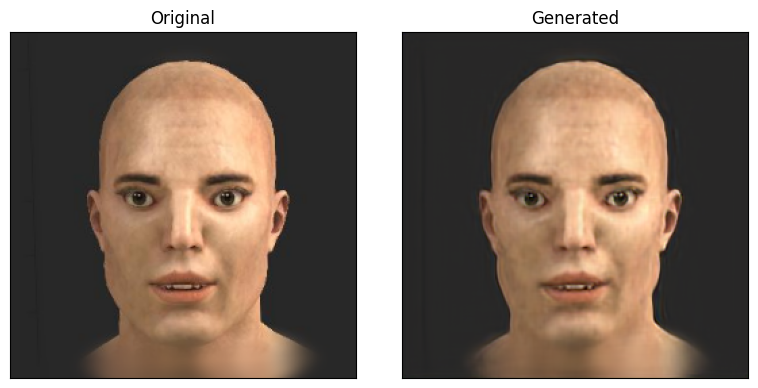

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


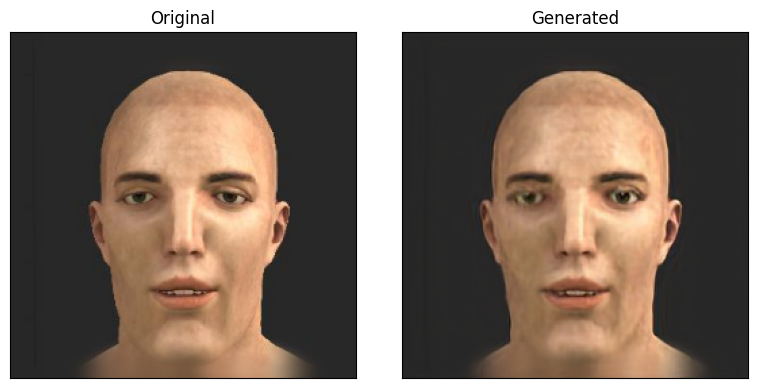

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


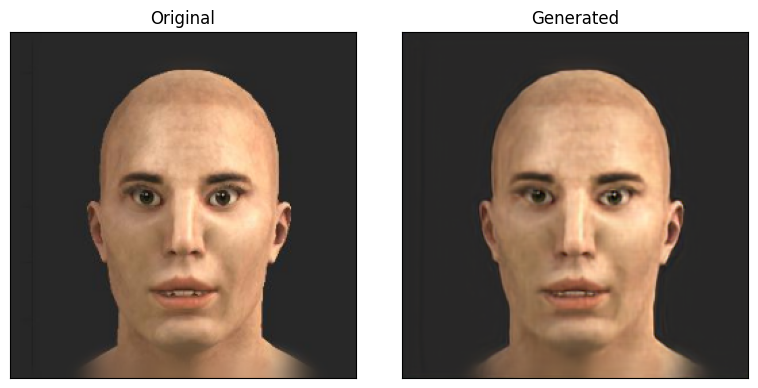

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


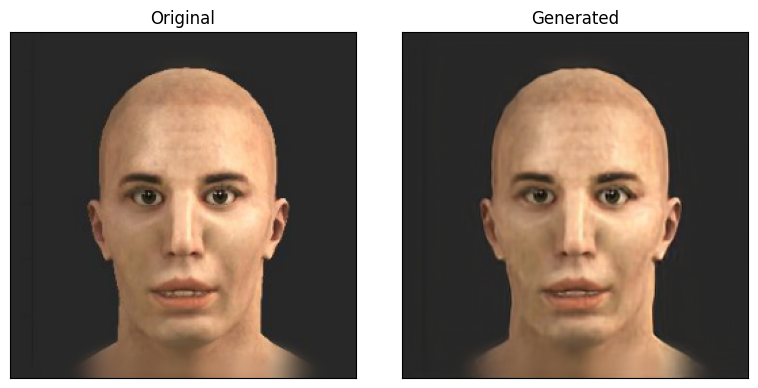

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


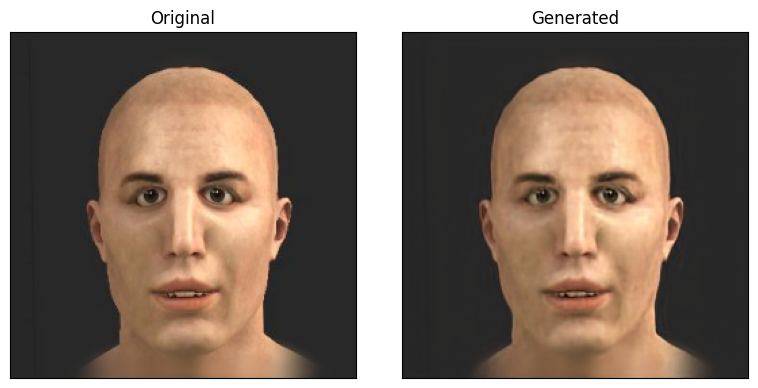

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


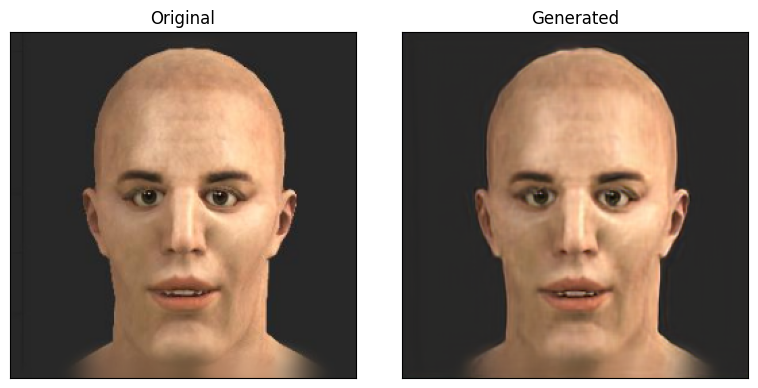

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


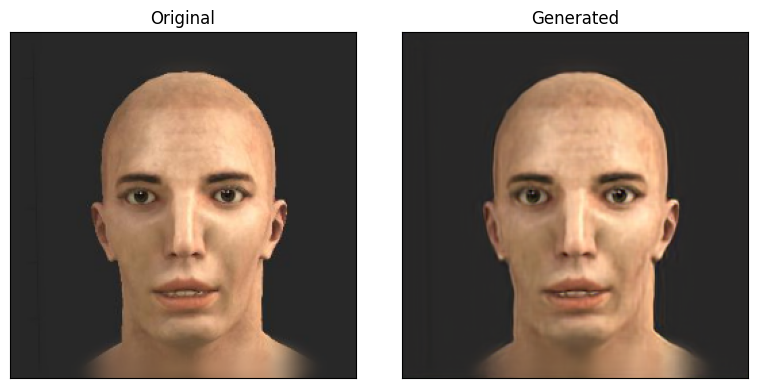

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


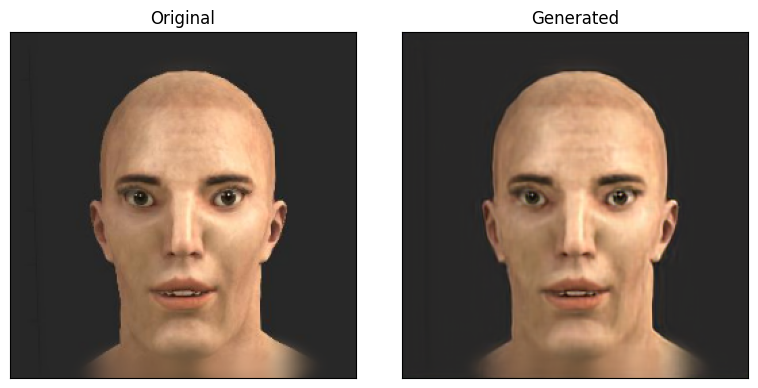

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


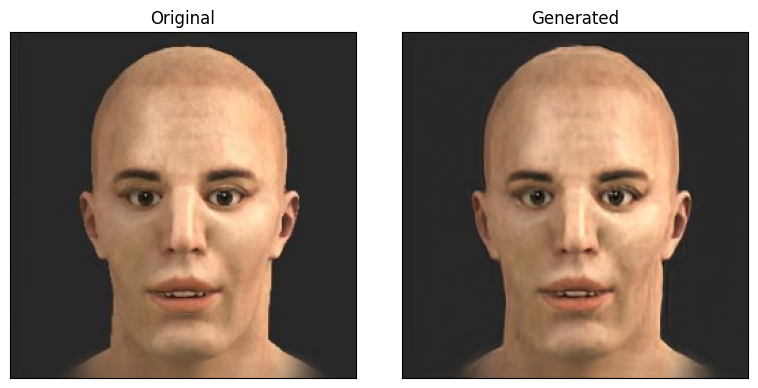

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


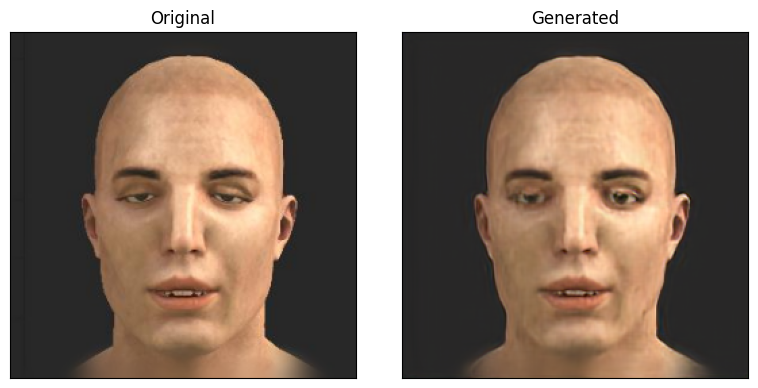

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


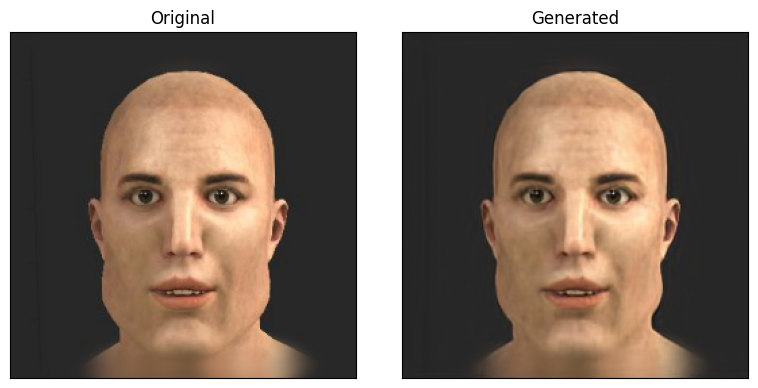

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


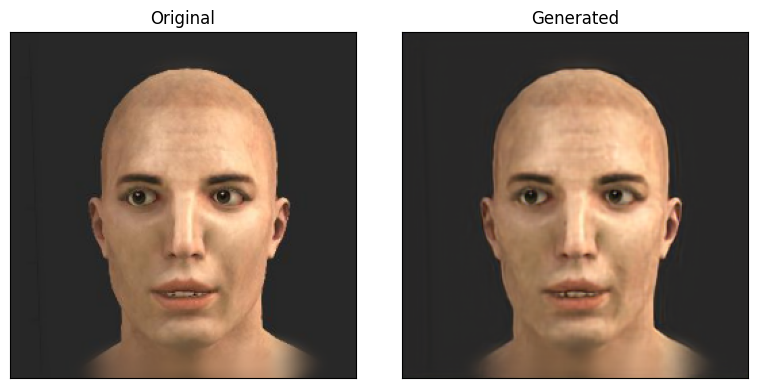

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


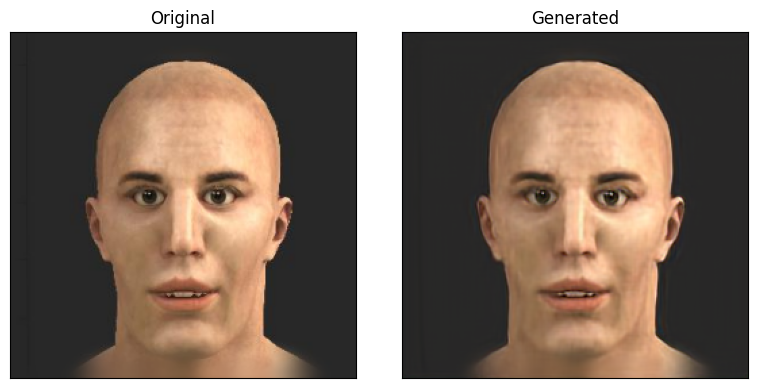

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


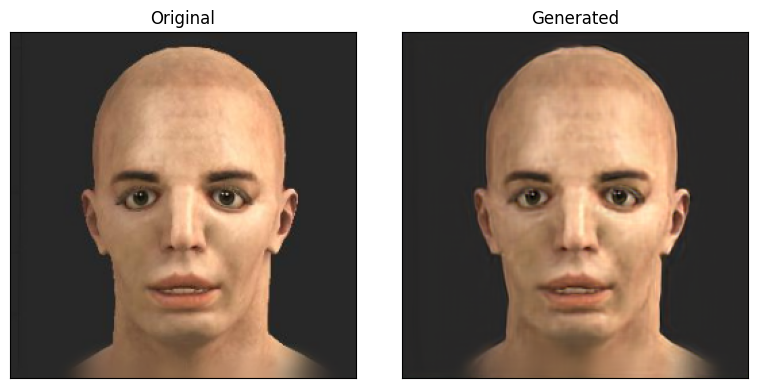

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


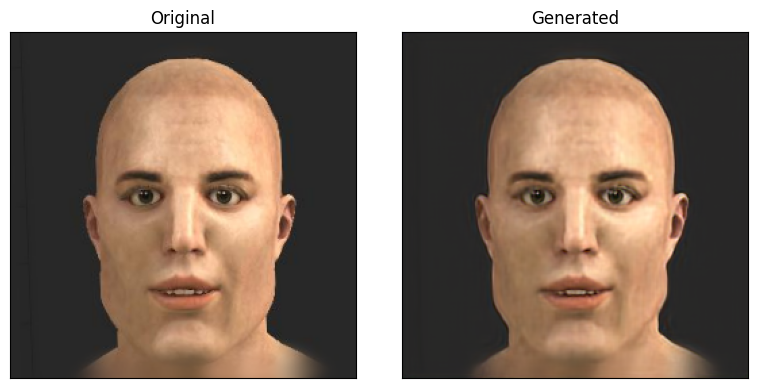

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


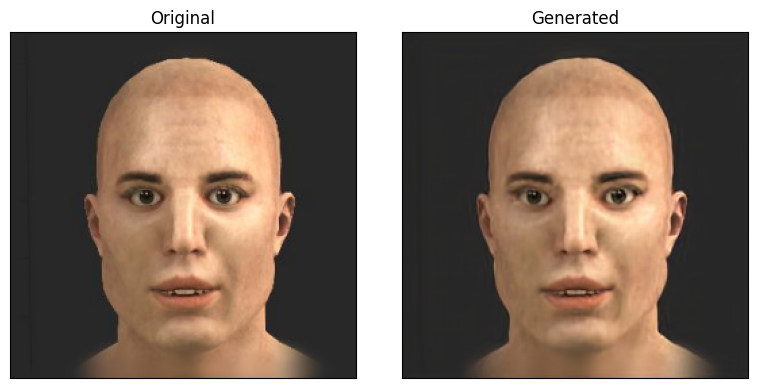

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


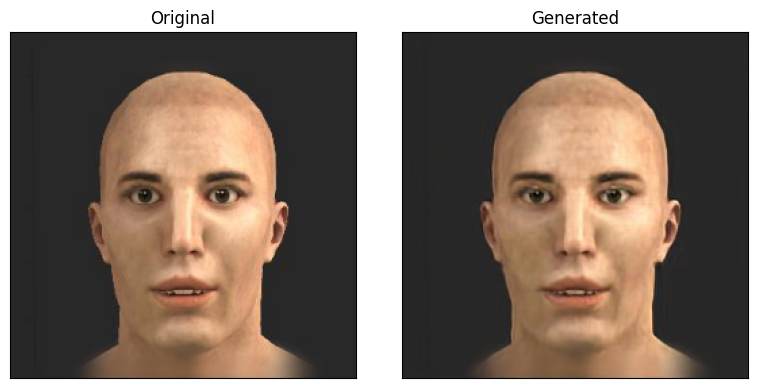

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


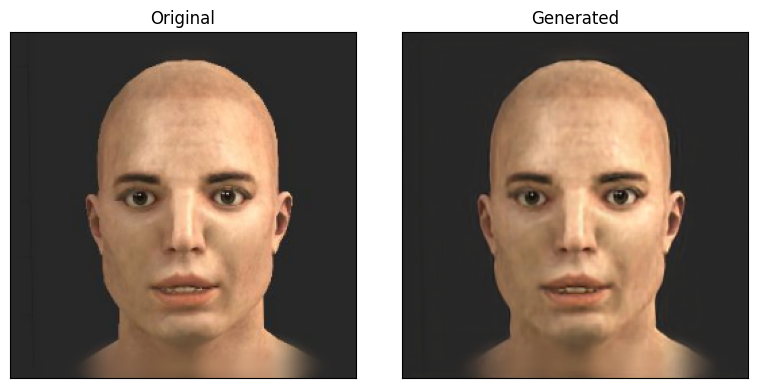

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


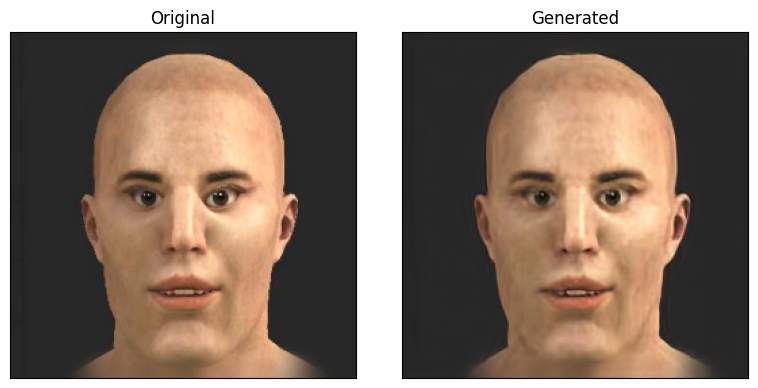

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


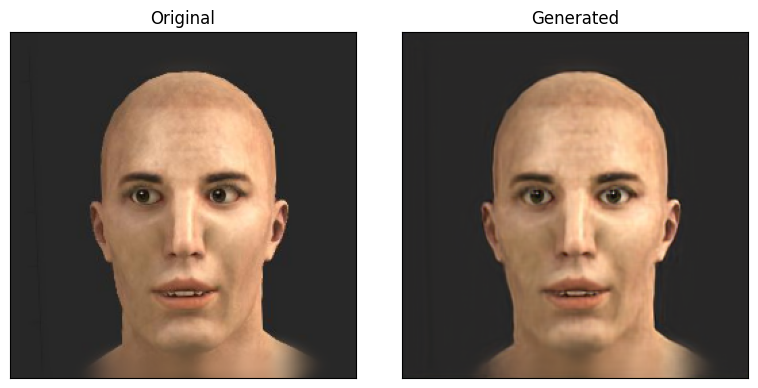

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


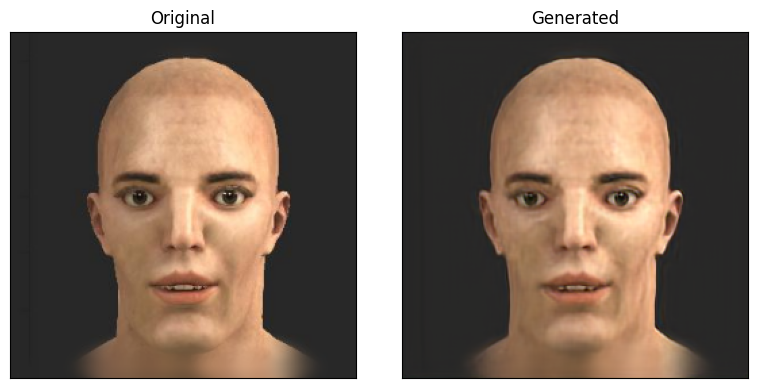

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


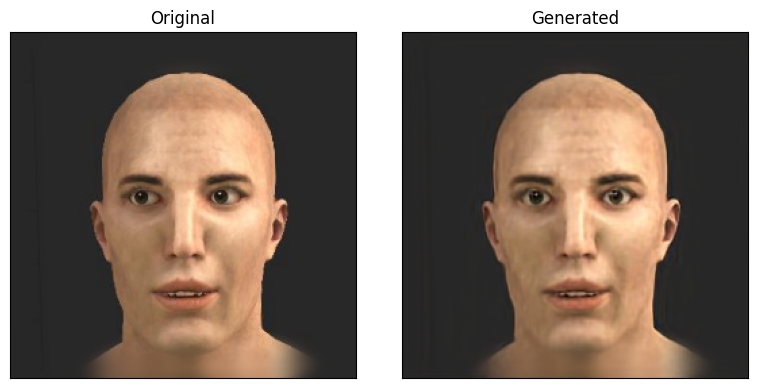

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


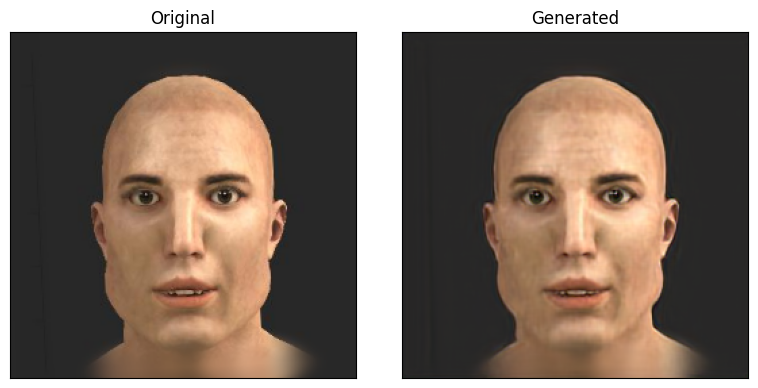

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


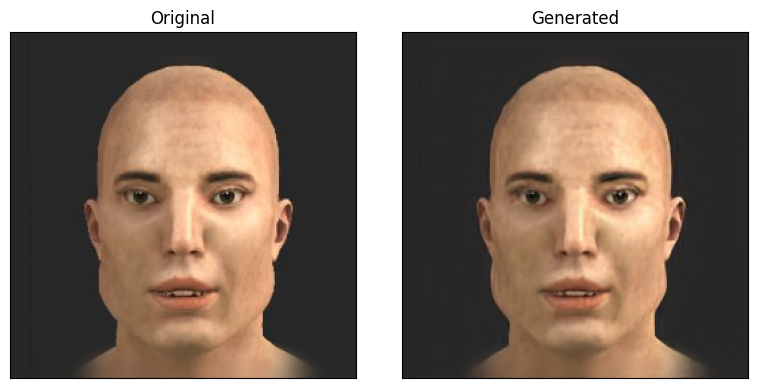

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


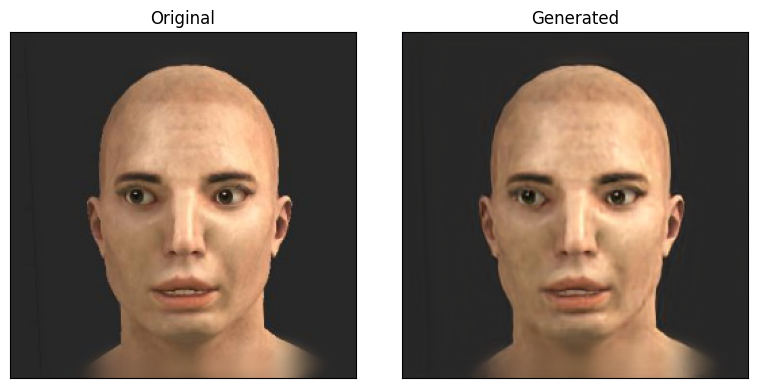

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


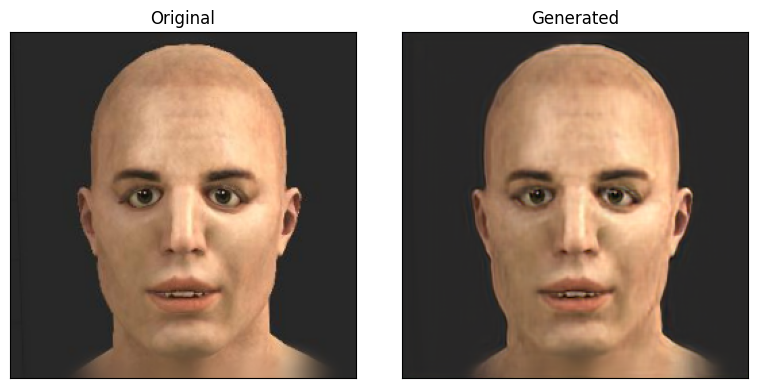

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


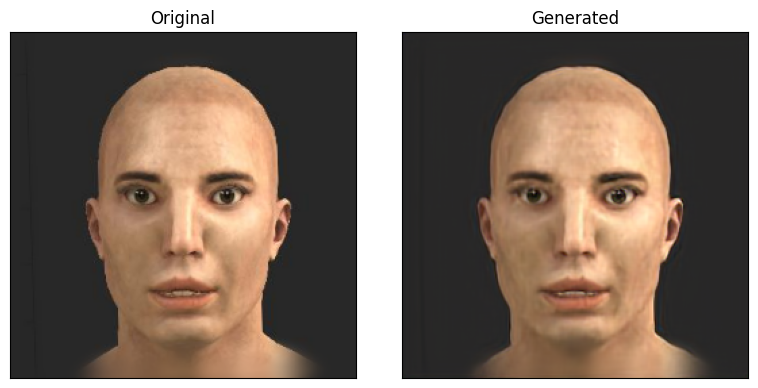

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


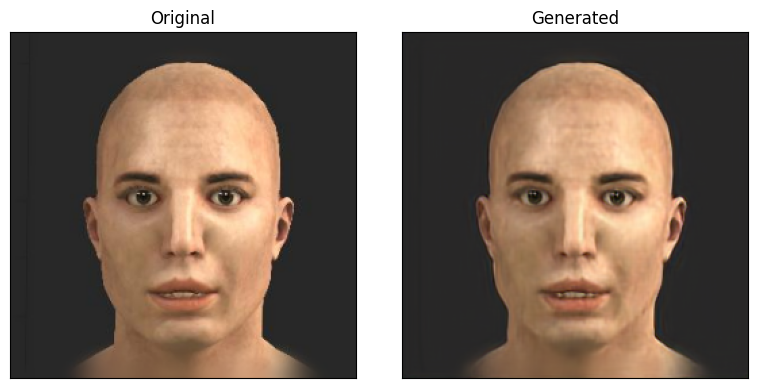

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


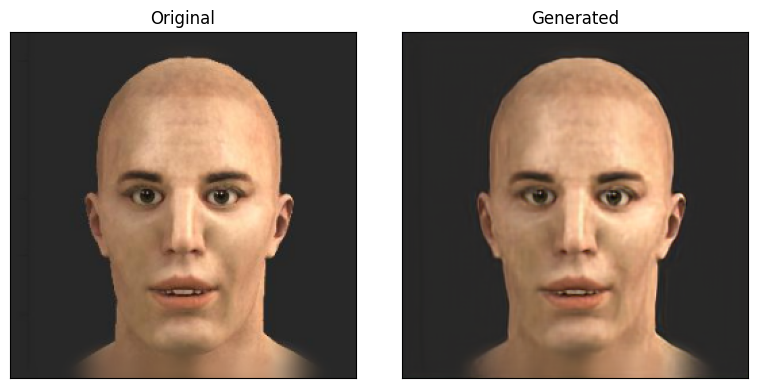

In [ ]:
zs = np.concatenate([np.load(z) for z in saved_z])
generated_images = [generator(torch.tensor(z).unsqueeze(0).to(DEVICE)).detach().to('cpu')[0].permute((1,2,0)) for z in zs]

for generated_image, original_image in zip(generated_images[:30], files_that_were_infered[:30]):
    plot_images([original_image, generated_image], ["Original", "Generated"], 1, 2, figsize=[8, 4])


In [ ]:
## Getting the generator

curr_generator = torch.load("./model/generator.pt").eval().cuda(0)
curr_gen_state_dict = curr_generator.state_dict()

In [ ]:
new_generator = Generator()
new_generator.load_state_dict(curr_gen_state_dict)
new_generator.cuda(0).eval()

Generator(
  (initial_conv): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GLU(dim=1)
  )
  (layers): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (0): PixelShuffleUpsample(
          (net): Sequential(
            (0): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1))
            (1): SiLU()
            (2): PixelShuffle(upscale_factor=2)
          )
        )
        (1): Blur()
        (2): Sequential(
          (0): ZeroPad2d((2, 1, 2, 1))
          (1): Conv2d(256, 1024, kernel_size=(4, 4), stride=(1, 1))
        )
        (3): Noise()
        (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): GLU(dim=1)
      )
      (1-2): 2 x None
    )
    (1): ModuleList(
      (0): Sequential(
        (0): PixelShuffleUpsample(
          (net): Sequential(
            (0): Conv2d(512, 2048

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[0.1514, 0.1638, 0.1339,  ..., 0.1600, 0.1478, 0.1899],
         [0.1529, 0.1148, 0.1375,  ..., 0.1678, 0.1627, 0.1946],
         [0.1643, 0.1712, 0.1551,  ..., 0.1674, 0.1711, 0.1428],
         ...,
         [0.1503, 0.1457, 0.1430,  ..., 0.1606, 0.1500, 0.1631],
         [0.1791, 0.1747, 0.1304,  ..., 0.1523, 0.1453, 0.1410],
         [0.1524, 0.1126, 0.1334,  ..., 0.1643, 0.1916, 0.1457]],

        [[0.1473, 0.1705, 0.1415,  ..., 0.1485, 0.1292, 0.1921],
         [0.1442, 0.1140, 0.1323,  ..., 0.1528, 0.1689, 0.1863],
         [0.1474, 0.1567, 0.1509,  ..., 0.1671, 0.1604, 0.1470],
         ...,
         [0.1538, 0.1489, 0.1515,  ..., 0.1595, 0.1543, 0.1729],
         [0.1669, 0.1479, 0.1466,  ..., 0.1586, 0.1426, 0.2055],
         [0.1526, 0.1757, 0.1542,  ..., 0.1630, 0.1627, 0.1606]],

        [[0.1493, 0.0939, 0.1085,  ..., 0.1547, 0.1503, 0.1427],
         [0.1166, 0.2169, 0.1840,  ..., 0.1522, 0.1726, 0.1889],
         [0.1444, 0.1589, 0.1658,  ..., 0.1540, 0.1742, 0.

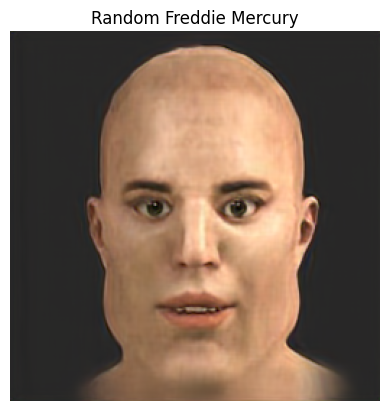

In [ ]:

random_latent_vectors = torch.randn( (1, LATENT_DIM) ).cuda(0)
generated_images = new_generator(random_latent_vectors)
show_tensor_picture(generated_images[0], title="Random Freddie Mercury")
print(generated_images[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[0.1518, 0.1638, 0.1339,  ..., 0.1603, 0.1476, 0.1896],
         [0.1529, 0.1145, 0.1375,  ..., 0.1674, 0.1624, 0.1946],
         [0.1644, 0.1714, 0.1555,  ..., 0.1676, 0.1710, 0.1425],
         ...,
         [0.1504, 0.1453, 0.1431,  ..., 0.1606, 0.1500, 0.1626],
         [0.1790, 0.1740, 0.1300,  ..., 0.1527, 0.1455, 0.1407],
         [0.1525, 0.1127, 0.1335,  ..., 0.1642, 0.1914, 0.1461]],

        [[0.1478, 0.1702, 0.1417,  ..., 0.1487, 0.1288, 0.1917],
         [0.1444, 0.1139, 0.1322,  ..., 0.1526, 0.1689, 0.1861],
         [0.1473, 0.1569, 0.1509,  ..., 0.1672, 0.1603, 0.1471],
         ...,
         [0.1538, 0.1488, 0.1512,  ..., 0.1596, 0.1545, 0.1730],
         [0.1668, 0.1478, 0.1462,  ..., 0.1587, 0.1429, 0.2054],
         [0.1523, 0.1759, 0.1543,  ..., 0.1629, 0.1622, 0.1609]],

        [[0.1498, 0.0936, 0.1085,  ..., 0.1547, 0.1501, 0.1429],
         [0.1165, 0.2172, 0.1840,  ..., 0.1524, 0.1724, 0.1886],
         [0.1445, 0.1589, 0.1661,  ..., 0.1540, 0.1743, 0.

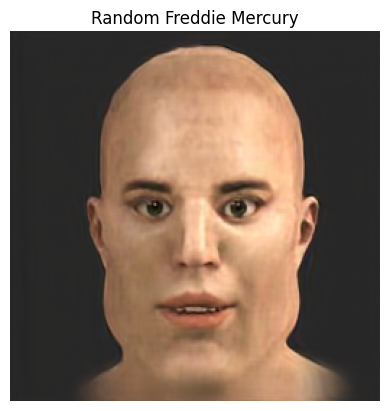

In [ ]:

generated_images = curr_generator(random_latent_vectors)
show_tensor_picture(generated_images[0], title="Random Freddie Mercury")
print(generated_images[0])

In [ ]:
print(torch.load("./model/generator_dict.pt"))

OrderedDict([('initial_conv.0.weight', tensor([[[[ 2.1945e-02,  1.3937e-02,  8.6343e-03, -1.3683e-02],
          [ 3.7564e-02, -2.0644e-02, -5.9363e-03,  8.2442e-03],
          [ 1.1671e-02, -1.3411e-03,  1.8694e-03, -9.8720e-03],
          [-8.4196e-02,  1.6371e-02, -1.1317e-02,  3.6690e-02]],

         [[ 1.3165e-02,  1.6251e-03, -3.0553e-02,  7.4924e-02],
          [ 1.4236e-02, -4.1023e-03, -4.0598e-02,  2.9369e-02],
          [ 3.4565e-03,  1.8551e-02, -7.3501e-03,  2.9866e-02],
          [-1.3493e-02, -9.6803e-03,  1.4476e-02,  6.0597e-03]],

         [[-1.3653e-02,  1.5510e-02,  1.2064e-03,  2.9922e-02],
          [ 1.6325e-02,  6.0198e-02, -2.3348e-02, -2.4253e-02],
          [-3.1609e-02,  3.0550e-02,  4.6724e-04, -4.6538e-02],
          [-4.3037e-02,  4.0065e-03,  1.9963e-02, -2.9572e-02]],

         ...,

         [[ 3.4171e-02, -1.1654e-02, -2.0458e-03,  1.1693e-02],
          [ 7.5846e-03,  3.5234e-02, -2.3566e-02,  1.8395e-02],
          [ 8.9638e-04, -1.2546e-02, -1.0394

In [ ]:
print(curr_gen_state_dict)

OrderedDict([('initial_conv.0.weight', tensor([[[[ 2.1945e-02,  1.3937e-02,  8.6343e-03, -1.3683e-02],
          [ 3.7564e-02, -2.0644e-02, -5.9363e-03,  8.2442e-03],
          [ 1.1671e-02, -1.3411e-03,  1.8694e-03, -9.8720e-03],
          [-8.4196e-02,  1.6371e-02, -1.1317e-02,  3.6690e-02]],

         [[ 1.3165e-02,  1.6251e-03, -3.0553e-02,  7.4924e-02],
          [ 1.4236e-02, -4.1023e-03, -4.0598e-02,  2.9369e-02],
          [ 3.4565e-03,  1.8551e-02, -7.3501e-03,  2.9866e-02],
          [-1.3493e-02, -9.6803e-03,  1.4476e-02,  6.0597e-03]],

         [[-1.3653e-02,  1.5510e-02,  1.2064e-03,  2.9922e-02],
          [ 1.6325e-02,  6.0198e-02, -2.3348e-02, -2.4253e-02],
          [-3.1609e-02,  3.0550e-02,  4.6724e-04, -4.6538e-02],
          [-4.3037e-02,  4.0065e-03,  1.9963e-02, -2.9572e-02]],

         ...,

         [[ 3.4171e-02, -1.1654e-02, -2.0458e-03,  1.1693e-02],
          [ 7.5846e-03,  3.5234e-02, -2.3566e-02,  1.8395e-02],
          [ 8.9638e-04, -1.2546e-02, -1.0394

In [ ]:
torch.save(curr_gen_state_dict, "./model/generator_dict.pt")

In [ ]:
state_dict = torch.load("./model/generator_dict.pt")